# Chapter 6: Q-Learning and SARSA Extensions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adiel2012/reinforcement-learning/blob/main/notebooks/chapter06_q_learning_extensions.ipynb)

This notebook implements advanced Q-learning variants including SARSA, Expected SARSA, and Double Q-learning with practical examples and convergence analysis.

## References
- **Watkins & Dayan (1992)**: Q-learning algorithm foundation [4]
- **Van Hasselt et al. (2016)**: Double Q-learning to address maximization bias [6]
- **Sutton & Barto (2018)**: Comprehensive treatment of temporal difference methods [1]

## Cross-References
- **Prerequisites**: Chapter 5 (Temporal Difference Learning)
- **Next**: Chapter 7 (Function Approximation)
- **Related**: Chapter 4 (Monte Carlo Methods), Chapter 8 (Deep RL)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
from tqdm import tqdm

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
random.seed(42)

## 6.1 Environment Setup: Windy Gridworld

We'll use a more complex environment to demonstrate the differences between Q-learning variants.

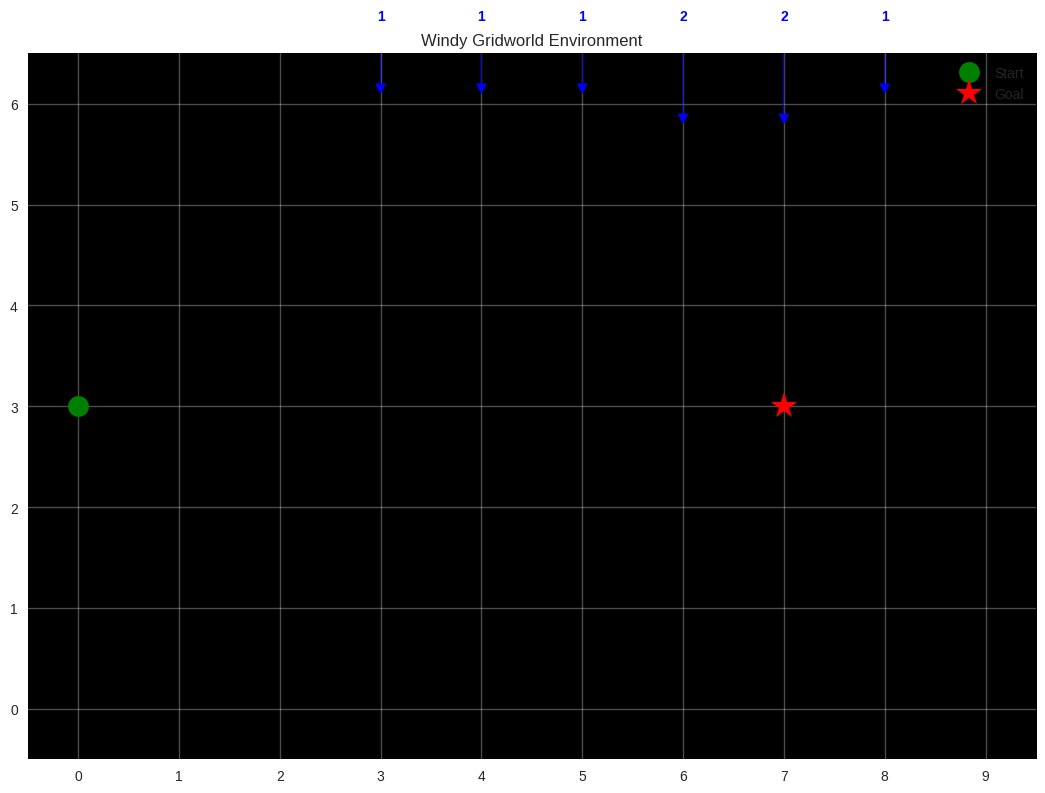

Environment: 7x10 grid
Start: (3, 0), Goal: (3, 7)
Wind pattern: [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]


In [2]:
class WindyGridworld:
    def __init__(self, height=7, width=10, wind_strength=None):
        self.height = height
        self.width = width
        self.start = (3, 0)
        self.goal = (3, 7)

        # Wind strength for each column
        if wind_strength is None:
            self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        else:
            self.wind = wind_strength

        # Actions: 0=up, 1=right, 2=down, 3=left
        self.actions = [0, 1, 2, 3]
        self.action_effects = [(-1, 0), (0, 1), (1, 0), (0, -1)]

        self.reset()

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        row, col = self.state

        # Apply action
        drow, dcol = self.action_effects[action]
        new_row = row + drow
        new_col = col + dcol

        # Apply wind (upward)
        wind_effect = self.wind[min(col, len(self.wind)-1)]
        new_row -= wind_effect

        # Bounds checking
        new_row = max(0, min(self.height-1, new_row))
        new_col = max(0, min(self.width-1, new_col))

        self.state = (new_row, new_col)

        # Reward structure
        if self.state == self.goal:
            reward = 0
            done = True
        else:
            reward = -1
            done = False

        return self.state, reward, done

    def get_valid_actions(self, state=None):
        return self.actions

    def visualize(self, policy=None, values=None):
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create grid
        grid = np.zeros((self.height, self.width))

        if values is not None:
            for (r, c), v in values.items():
                grid[r, c] = v

            im = ax.imshow(grid, cmap='RdYlBu_r')
            plt.colorbar(im, label='State Value')
        else:
            im = ax.imshow(grid, cmap='gray')

        # Mark special states
        ax.plot(self.start[1], self.start[0], 'go', markersize=15, label='Start')
        ax.plot(self.goal[1], self.goal[0], 'r*', markersize=20, label='Goal')

        # Show wind
        for col, strength in enumerate(self.wind):
            if strength > 0:
                ax.arrow(col, self.height-0.5, 0, -0.3*strength,
                        head_width=0.1, head_length=0.1, fc='blue', ec='blue')
                ax.text(col, self.height-0.2, str(strength),
                       ha='center', va='bottom', color='blue', fontweight='bold')

        # Show policy arrows
        if policy is not None:
            arrow_map = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)}
            for (r, c), action in policy.items():
                if (r, c) != self.goal:
                    dx, dy = arrow_map[action]
                    ax.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1,
                            fc='white', ec='black', linewidth=2)

        ax.set_xlim(-0.5, self.width-0.5)
        ax.set_ylim(-0.5, self.height-0.5)
        ax.set_xticks(range(self.width))
        ax.set_yticks(range(self.height))
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_title('Windy Gridworld Environment')

        plt.tight_layout()
        plt.show()

# Test the environment
env = WindyGridworld()
env.visualize()
print(f"Environment: {env.height}x{env.width} grid")
print(f"Start: {env.start}, Goal: {env.goal}")
print(f"Wind pattern: {env.wind}")

## 6.2 SARSA Implementation

SARSA (State-Action-Reward-State-Action) is an on-policy TD control algorithm.

Training SARSA agent...


100%|██████████| 500/500 [00:00<00:00, 802.75it/s]


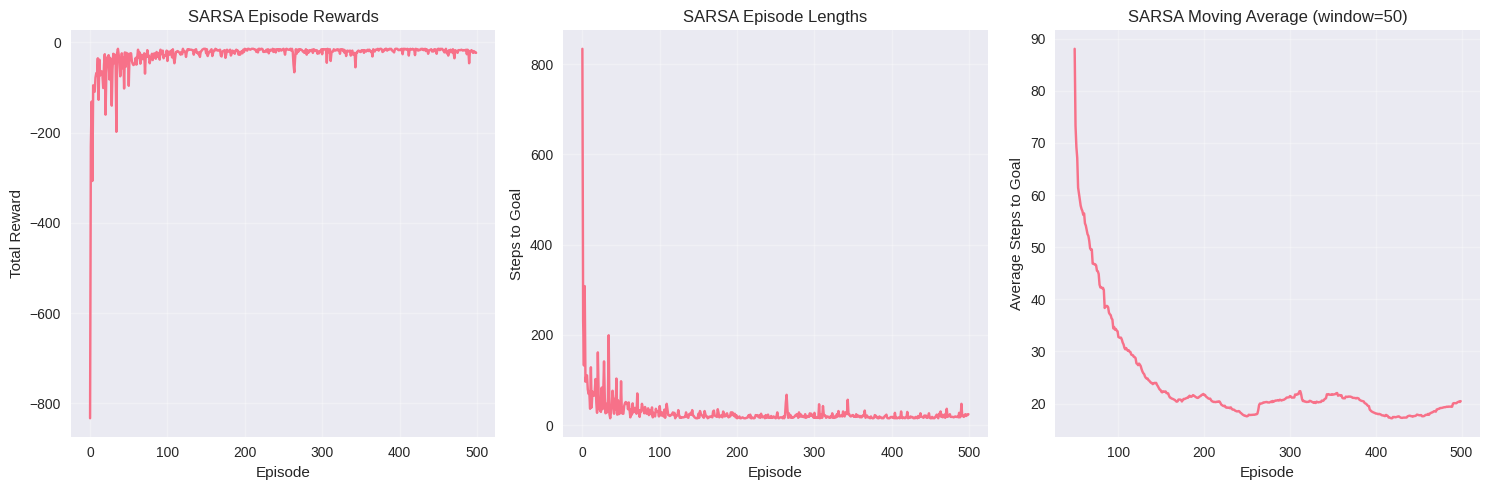

Final average episode length (last 100 episodes): 19.17


In [3]:
class SARSAAgent:
    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table
        self.Q = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.episode_lengths = []

    def epsilon_greedy_policy(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.get_valid_actions(state))
        else:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            max_q = max(q_values)
            # Break ties randomly
            best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
            return np.random.choice(best_actions)

    def train_episode(self):
        """Train for one episode using SARSA"""
        state = self.env.reset()
        action = self.epsilon_greedy_policy(state)

        episode_reward = 0
        steps = 0

        while True:
            # Take action
            next_state, reward, done = self.env.step(action)
            episode_reward += reward
            steps += 1

            if done:
                # Terminal state update
                self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
                break
            else:
                # Choose next action
                next_action = self.epsilon_greedy_policy(next_state)

                # SARSA update
                td_target = reward + self.gamma * self.Q[next_state][next_action]
                td_error = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_error

                # Move to next state-action pair
                state = next_state
                action = next_action

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)
        return episode_reward, steps

    def get_policy(self):
        """Extract greedy policy from Q-values"""
        policy = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            best_action = actions[np.argmax(q_values)]
            policy[state] = best_action
        return policy

    def get_state_values(self):
        """Extract state values from Q-values"""
        values = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            values[state] = max(q_values) if q_values else 0
        return values

# Train SARSA agent
env = WindyGridworld()
sarsa_agent = SARSAAgent(env, alpha=0.5, epsilon=0.1)

print("Training SARSA agent...")
episodes = 500
for episode in tqdm(range(episodes)):
    sarsa_agent.train_episode()

# Plot learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(sarsa_agent.episode_rewards)
plt.title('SARSA Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(sarsa_agent.episode_lengths)
plt.title('SARSA Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Moving average
window = 50
moving_avg = np.convolve(sarsa_agent.episode_lengths, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(sarsa_agent.episode_lengths)), moving_avg)
plt.title(f'SARSA Moving Average (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Steps to Goal')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final average episode length (last 100 episodes): {np.mean(sarsa_agent.episode_lengths[-100:]):.2f}")

## 6.3 Q-Learning Implementation

Q-Learning is an off-policy TD control algorithm that learns the optimal policy regardless of the behavior policy.

In [4]:
class QLearningAgent:
    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table
        self.Q = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.episode_lengths = []

    def epsilon_greedy_policy(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.get_valid_actions(state))
        else:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
            return np.random.choice(best_actions)

    def train_episode(self):
        """Train for one episode using Q-Learning"""
        state = self.env.reset()

        episode_reward = 0
        steps = 0

        while True:
            # Choose action using behavior policy (epsilon-greedy)
            action = self.epsilon_greedy_policy(state)

            # Take action
            next_state, reward, done = self.env.step(action)
            episode_reward += reward
            steps += 1

            if done:
                # Terminal state update
                self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
                break
            else:
                # Q-Learning update (off-policy)
                actions = self.env.get_valid_actions(next_state)
                max_next_q = max([self.Q[next_state][a] for a in actions])

                td_target = reward + self.gamma * max_next_q
                td_error = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_error

                state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)
        return episode_reward, steps

    def get_policy(self):
        """Extract greedy policy from Q-values"""
        policy = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            best_action = actions[np.argmax(q_values)]
            policy[state] = best_action
        return policy

    def get_state_values(self):
        """Extract state values from Q-values"""
        values = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            values[state] = max(q_values) if q_values else 0
        return values

# Train Q-Learning agent
env = WindyGridworld()
qlearning_agent = QLearningAgent(env, alpha=0.5, epsilon=0.1)

print("Training Q-Learning agent...")
episodes = 500
for episode in tqdm(range(episodes)):
    qlearning_agent.train_episode()

print(f"Final average episode length (last 100 episodes): {np.mean(qlearning_agent.episode_lengths[-100:]):.2f}")

Training Q-Learning agent...


100%|██████████| 500/500 [00:01<00:00, 401.81it/s]

Final average episode length (last 100 episodes): 16.95


## 6.4 Expected SARSA Implementation

Expected SARSA uses the expected value over all possible next actions, weighted by their selection probabilities.

In [5]:
class ExpectedSARSAAgent:
    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table
        self.Q = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.episode_lengths = []

    def epsilon_greedy_policy(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.get_valid_actions(state))
        else:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
            return np.random.choice(best_actions)

    def expected_value(self, state):
        """Calculate expected value under epsilon-greedy policy"""
        actions = self.env.get_valid_actions(state)
        q_values = [self.Q[state][a] for a in actions]

        # Find best action(s)
        max_q = max(q_values)
        num_best = sum(1 for q in q_values if q == max_q)

        expected_q = 0
        for action, q_val in zip(actions, q_values):
            if q_val == max_q:
                # Probability for best actions
                prob = (1 - self.epsilon) / num_best + self.epsilon / len(actions)
            else:
                # Probability for non-best actions
                prob = self.epsilon / len(actions)

            expected_q += prob * q_val

        return expected_q

    def train_episode(self):
        """Train for one episode using Expected SARSA"""
        state = self.env.reset()

        episode_reward = 0
        steps = 0

        while True:
            # Choose action
            action = self.epsilon_greedy_policy(state)

            # Take action
            next_state, reward, done = self.env.step(action)
            episode_reward += reward
            steps += 1

            if done:
                # Terminal state update
                self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
                break
            else:
                # Expected SARSA update
                expected_next_q = self.expected_value(next_state)
                td_target = reward + self.gamma * expected_next_q
                td_error = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_error

                state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)
        return episode_reward, steps

    def get_policy(self):
        """Extract greedy policy from Q-values"""
        policy = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            best_action = actions[np.argmax(q_values)]
            policy[state] = best_action
        return policy

    def get_state_values(self):
        """Extract state values from Q-values"""
        values = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            values[state] = max(q_values) if q_values else 0
        return values

# Train Expected SARSA agent
env = WindyGridworld()
expected_sarsa_agent = ExpectedSARSAAgent(env, alpha=0.5, epsilon=0.1)

print("Training Expected SARSA agent...")
episodes = 500
for episode in tqdm(range(episodes)):
    expected_sarsa_agent.train_episode()

print(f"Final average episode length (last 100 episodes): {np.mean(expected_sarsa_agent.episode_lengths[-100:]):.2f}")

Training Expected SARSA agent...


100%|██████████| 500/500 [00:01<00:00, 298.36it/s]

Final average episode length (last 100 episodes): 17.13


## 6.5 Double Q-Learning Implementation

Double Q-Learning addresses the maximization bias in Q-Learning by using two Q-tables.

In [6]:
class DoubleQLearningAgent:
    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize two Q-tables
        self.Q1 = defaultdict(lambda: defaultdict(float))
        self.Q2 = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.episode_lengths = []

    def get_combined_q(self, state, action):
        """Get combined Q-value from both tables"""
        return self.Q1[state][action] + self.Q2[state][action]

    def epsilon_greedy_policy(self, state):
        """Epsilon-greedy action selection using combined Q-values"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.get_valid_actions(state))
        else:
            actions = self.env.get_valid_actions(state)
            q_values = [self.get_combined_q(state, a) for a in actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
            return np.random.choice(best_actions)

    def train_episode(self):
        """Train for one episode using Double Q-Learning"""
        state = self.env.reset()

        episode_reward = 0
        steps = 0

        while True:
            # Choose action
            action = self.epsilon_greedy_policy(state)

            # Take action
            next_state, reward, done = self.env.step(action)
            episode_reward += reward
            steps += 1

            if done:
                # Terminal state update for both tables
                if np.random.random() < 0.5:
                    self.Q1[state][action] += self.alpha * (reward - self.Q1[state][action])
                else:
                    self.Q2[state][action] += self.alpha * (reward - self.Q2[state][action])
                break
            else:
                # Double Q-Learning update
                actions = self.env.get_valid_actions(next_state)

                if np.random.random() < 0.5:
                    # Update Q1, use Q2 for evaluation
                    q1_values = [self.Q1[next_state][a] for a in actions]
                    best_action = actions[np.argmax(q1_values)]
                    td_target = reward + self.gamma * self.Q2[next_state][best_action]
                    td_error = td_target - self.Q1[state][action]
                    self.Q1[state][action] += self.alpha * td_error
                else:
                    # Update Q2, use Q1 for evaluation
                    q2_values = [self.Q2[next_state][a] for a in actions]
                    best_action = actions[np.argmax(q2_values)]
                    td_target = reward + self.gamma * self.Q1[next_state][best_action]
                    td_error = td_target - self.Q2[state][action]
                    self.Q2[state][action] += self.alpha * td_error

                state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)
        return episode_reward, steps

    def get_policy(self):
        """Extract greedy policy from combined Q-values"""
        policy = {}
        all_states = set(list(self.Q1.keys()) + list(self.Q2.keys()))

        for state in all_states:
            actions = self.env.get_valid_actions(state)
            q_values = [self.get_combined_q(state, a) for a in actions]
            best_action = actions[np.argmax(q_values)]
            policy[state] = best_action
        return policy

    def get_state_values(self):
        """Extract state values from combined Q-values"""
        values = {}
        all_states = set(list(self.Q1.keys()) + list(self.Q2.keys()))

        for state in all_states:
            actions = self.env.get_valid_actions(state)
            q_values = [self.get_combined_q(state, a) for a in actions]
            values[state] = max(q_values) if q_values else 0
        return values

# Train Double Q-Learning agent
env = WindyGridworld()
double_q_agent = DoubleQLearningAgent(env, alpha=0.5, epsilon=0.1)

print("Training Double Q-Learning agent...")
episodes = 500
for episode in tqdm(range(episodes)):
    double_q_agent.train_episode()

print(f"Final average episode length (last 100 episodes): {np.mean(double_q_agent.episode_lengths[-100:]):.2f}")

Training Double Q-Learning agent...


100%|██████████| 500/500 [00:02<00:00, 246.71it/s]

Final average episode length (last 100 episodes): 17.29


## 6.6 Algorithm Comparison

Let's compare the performance of all four algorithms.

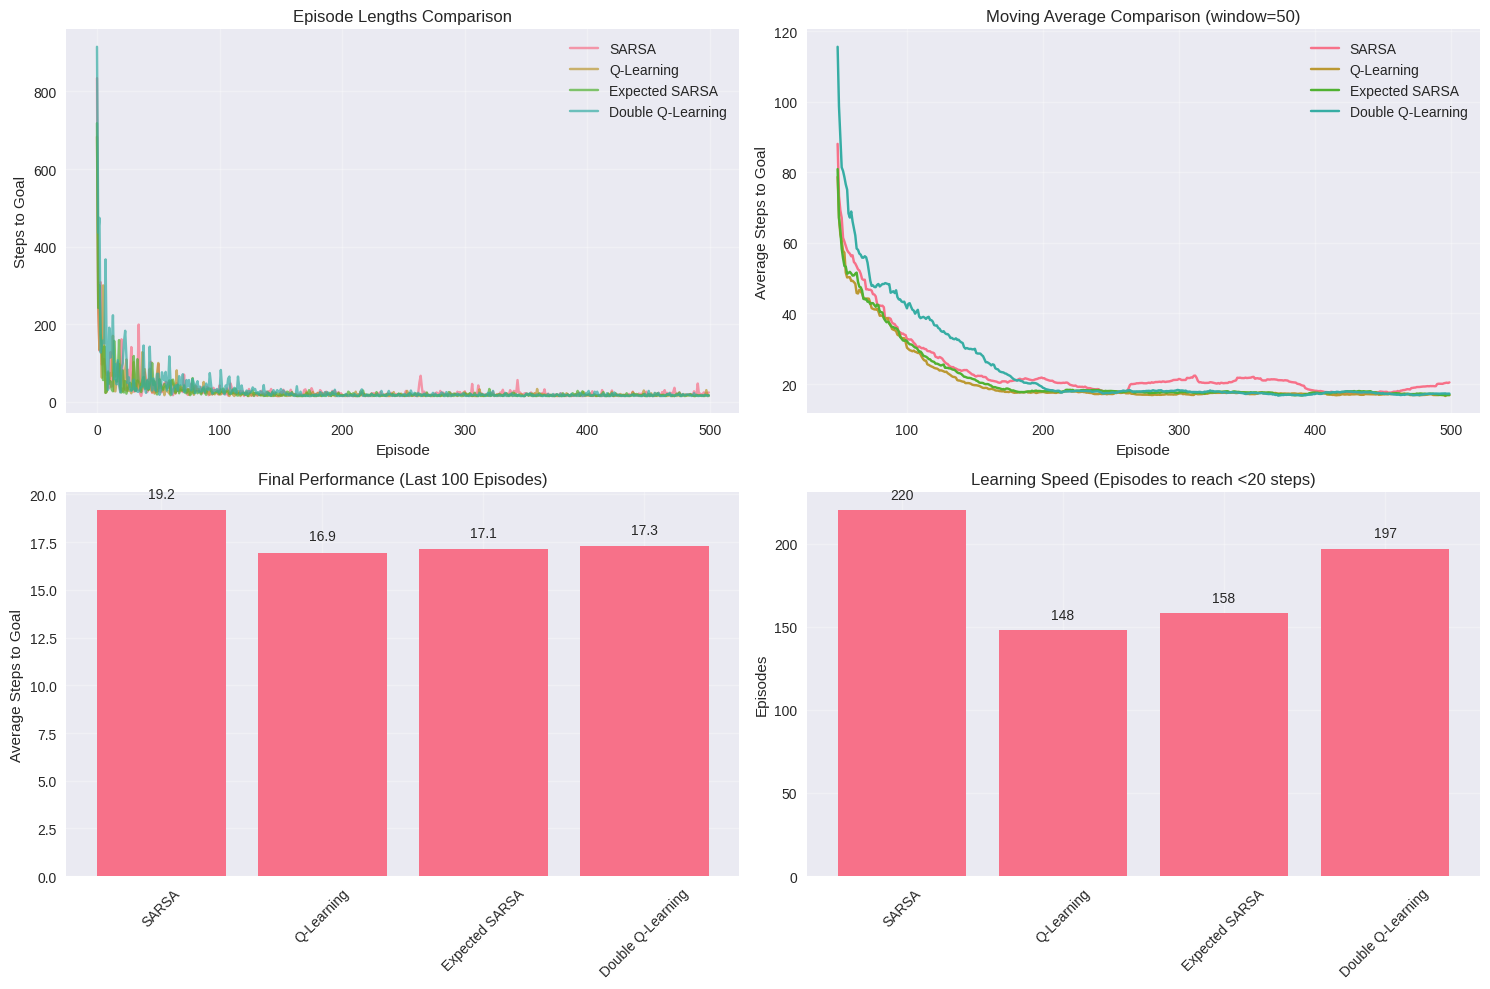


=== Algorithm Performance Summary ===
SARSA:
  Final performance: 19.17 ± 4.84 steps
  Learning speed: 220 episodes to reach <20 steps

Q-Learning:
  Final performance: 16.95 ± 2.73 steps
  Learning speed: 148 episodes to reach <20 steps

Expected SARSA:
  Final performance: 17.13 ± 2.12 steps
  Learning speed: 158 episodes to reach <20 steps

Double Q-Learning:
  Final performance: 17.29 ± 2.94 steps
  Learning speed: 197 episodes to reach <20 steps



In [7]:
# Compare learning curves
plt.figure(figsize=(15, 10))

# Episode lengths comparison
plt.subplot(2, 2, 1)
plt.plot(sarsa_agent.episode_lengths, label='SARSA', alpha=0.7)
plt.plot(qlearning_agent.episode_lengths, label='Q-Learning', alpha=0.7)
plt.plot(expected_sarsa_agent.episode_lengths, label='Expected SARSA', alpha=0.7)
plt.plot(double_q_agent.episode_lengths, label='Double Q-Learning', alpha=0.7)
plt.title('Episode Lengths Comparison')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

# Moving averages
plt.subplot(2, 2, 2)
window = 50
algorithms = [
    ('SARSA', sarsa_agent.episode_lengths),
    ('Q-Learning', qlearning_agent.episode_lengths),
    ('Expected SARSA', expected_sarsa_agent.episode_lengths),
    ('Double Q-Learning', double_q_agent.episode_lengths)
]

for name, lengths in algorithms:
    moving_avg = np.convolve(lengths, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(lengths)), moving_avg, label=name)

plt.title(f'Moving Average Comparison (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

# Final performance comparison
plt.subplot(2, 2, 3)
final_performances = []
algorithm_names = []

for name, lengths in algorithms:
    final_avg = np.mean(lengths[-100:])
    final_performances.append(final_avg)
    algorithm_names.append(name)

bars = plt.bar(algorithm_names, final_performances)
plt.title('Final Performance (Last 100 Episodes)')
plt.ylabel('Average Steps to Goal')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, final_performances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Learning speed comparison (episodes to reach performance threshold)
plt.subplot(2, 2, 4)
threshold = 20  # Steps to goal threshold
learning_speeds = []

for name, lengths in algorithms:
    # Find first episode where moving average goes below threshold
    moving_avg = np.convolve(lengths, np.ones(window)/window, mode='valid')
    first_good = np.where(moving_avg < threshold)[0]

    if len(first_good) > 0:
        learning_speed = first_good[0] + window - 1
    else:
        learning_speed = len(lengths)  # Never reached threshold

    learning_speeds.append(learning_speed)

bars = plt.bar(algorithm_names, learning_speeds)
plt.title(f'Learning Speed (Episodes to reach <{threshold} steps)')
plt.ylabel('Episodes')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, learning_speeds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{value}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Algorithm Performance Summary ===")
for i, (name, lengths) in enumerate(algorithms):
    final_avg = np.mean(lengths[-100:])
    final_std = np.std(lengths[-100:])
    learning_speed = learning_speeds[i]

    print(f"{name}:")
    print(f"  Final performance: {final_avg:.2f} ± {final_std:.2f} steps")
    print(f"  Learning speed: {learning_speed} episodes to reach <{threshold} steps")
    print()

## 6.7 Policy and Value Function Visualization

Let's visualize the learned policies and value functions.

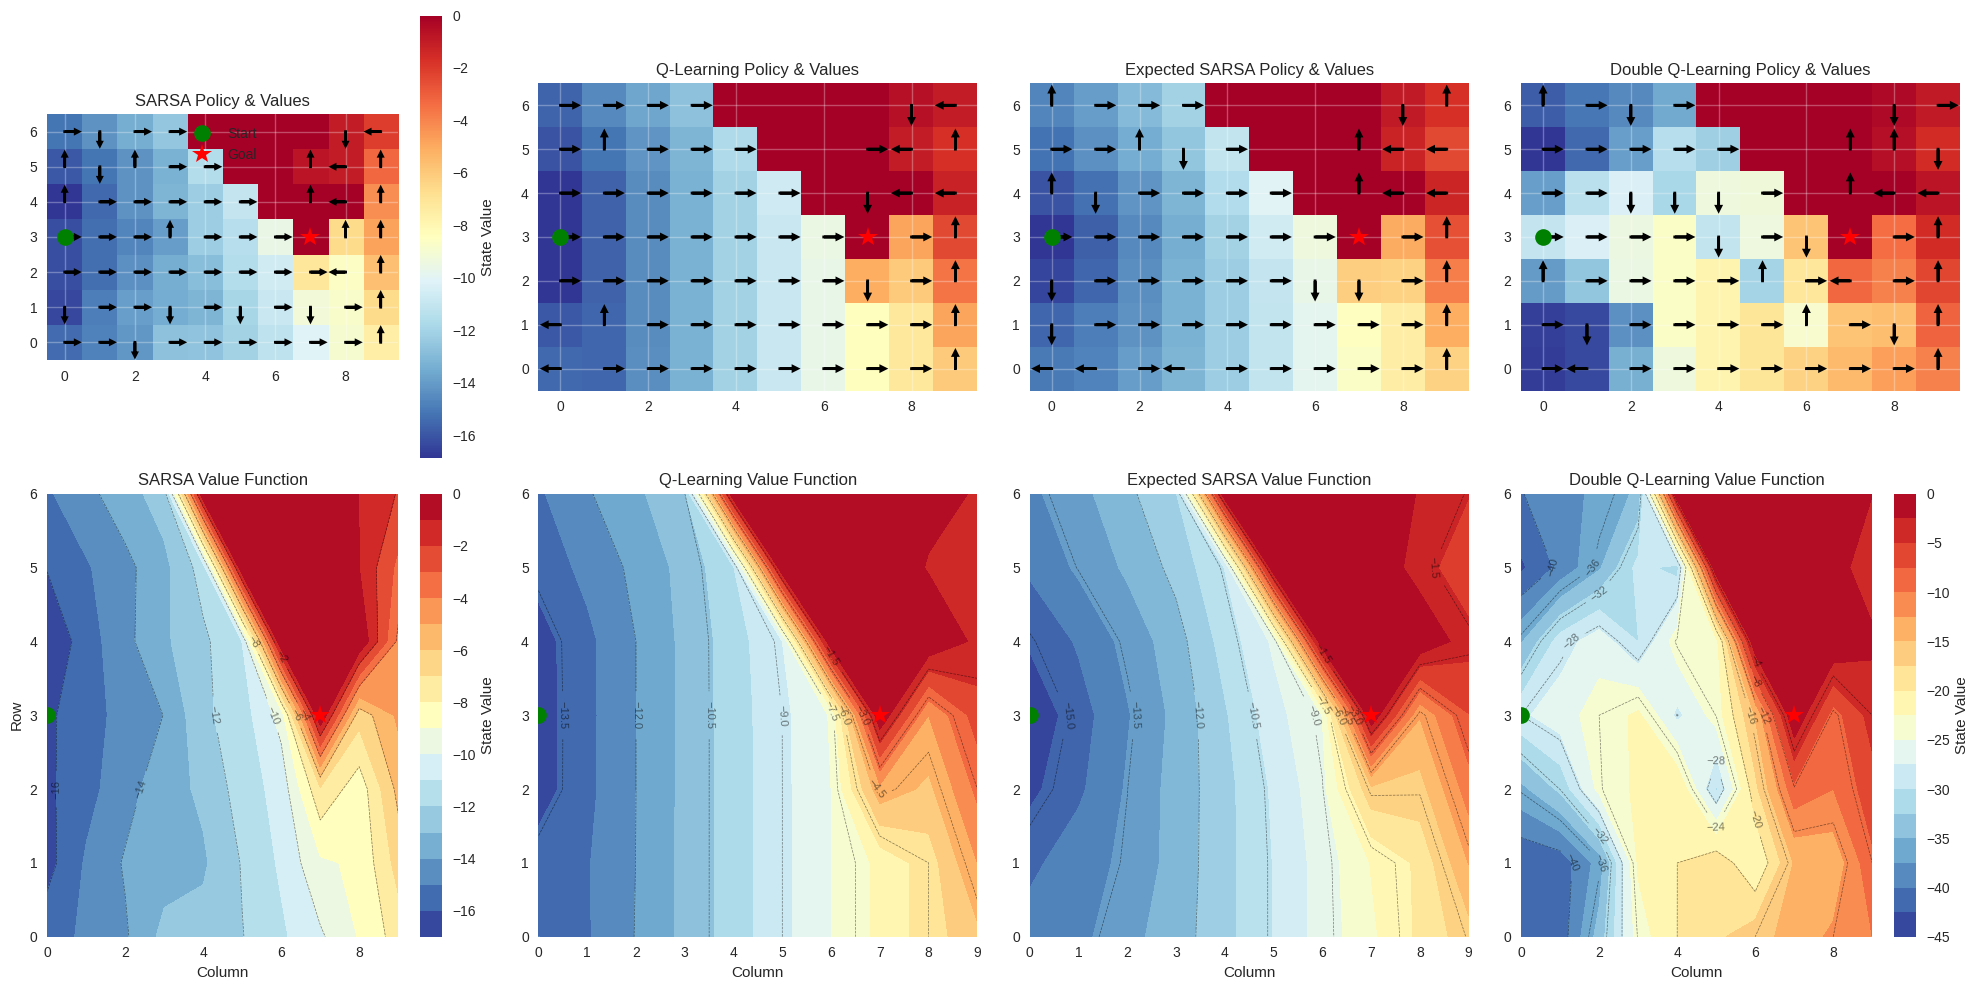

In [8]:
# Visualize policies and value functions
agents = [
    ('SARSA', sarsa_agent),
    ('Q-Learning', qlearning_agent),
    ('Expected SARSA', expected_sarsa_agent),
    ('Double Q-Learning', double_q_agent)
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, (name, agent) in enumerate(agents):
    policy = agent.get_policy()
    values = agent.get_state_values()

    # Create temporary environment for visualization
    temp_env = WindyGridworld()

    # Plot policy
    ax1 = axes[0, i]

    # Create grid for values
    value_grid = np.zeros((temp_env.height, temp_env.width))
    for (r, c), v in values.items():
        value_grid[r, c] = v

    im1 = ax1.imshow(value_grid, cmap='RdYlBu_r')

    # Add policy arrows
    arrow_map = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)}
    for (r, c), action in policy.items():
        if (r, c) != temp_env.goal:
            dx, dy = arrow_map[action]
            ax1.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1,
                     fc='white', ec='black', linewidth=2)

    # Mark special states
    ax1.plot(temp_env.start[1], temp_env.start[0], 'go', markersize=12, label='Start')
    ax1.plot(temp_env.goal[1], temp_env.goal[0], 'r*', markersize=15, label='Goal')

    ax1.set_title(f'{name} Policy & Values')
    ax1.set_xlim(-0.5, temp_env.width-0.5)
    ax1.set_ylim(-0.5, temp_env.height-0.5)
    ax1.grid(True, alpha=0.3)

    if i == 0:
        ax1.legend()

    # Plot value function as 3D surface
    ax2 = axes[1, i]

    # Create meshgrid for 3D plot
    X, Y = np.meshgrid(range(temp_env.width), range(temp_env.height))

    im2 = ax2.contourf(X, Y, value_grid, levels=20, cmap='RdYlBu_r')
    contours = ax2.contour(X, Y, value_grid, levels=10, colors='black', alpha=0.5, linewidths=0.5)
    ax2.clabel(contours, inline=True, fontsize=8)

    # Mark special states
    ax2.plot(temp_env.start[1], temp_env.start[0], 'go', markersize=12)
    ax2.plot(temp_env.goal[1], temp_env.goal[0], 'r*', markersize=15)

    ax2.set_title(f'{name} Value Function')
    ax2.set_xlabel('Column')
    if i == 0:
        ax2.set_ylabel('Row')

    # Add colorbar for first and last plots
    if i == 0:
        plt.colorbar(im1, ax=ax1, label='State Value')
        plt.colorbar(im2, ax=ax2, label='State Value')
    elif i == 3:
        plt.colorbar(im2, ax=ax2, label='State Value')

plt.tight_layout()
plt.show()

## 6.8 Convergence Analysis and TD($\lambda$) Introduction

Let's analyze the theoretical properties and introduce TD($\lambda$) methods.

Training SARSA(λ) agents with different λ values...
Training λ = 0.0...


λ=0.0: 100%|██████████| 300/300 [00:00<00:00, 792.48it/s]


Training λ = 0.3...


λ=0.3: 100%|██████████| 300/300 [00:00<00:00, 713.45it/s]


Training λ = 0.6...


λ=0.6: 100%|██████████| 300/300 [00:00<00:00, 680.54it/s]


Training λ = 0.9...


λ=0.9: 100%|██████████| 300/300 [00:00<00:00, 660.28it/s]


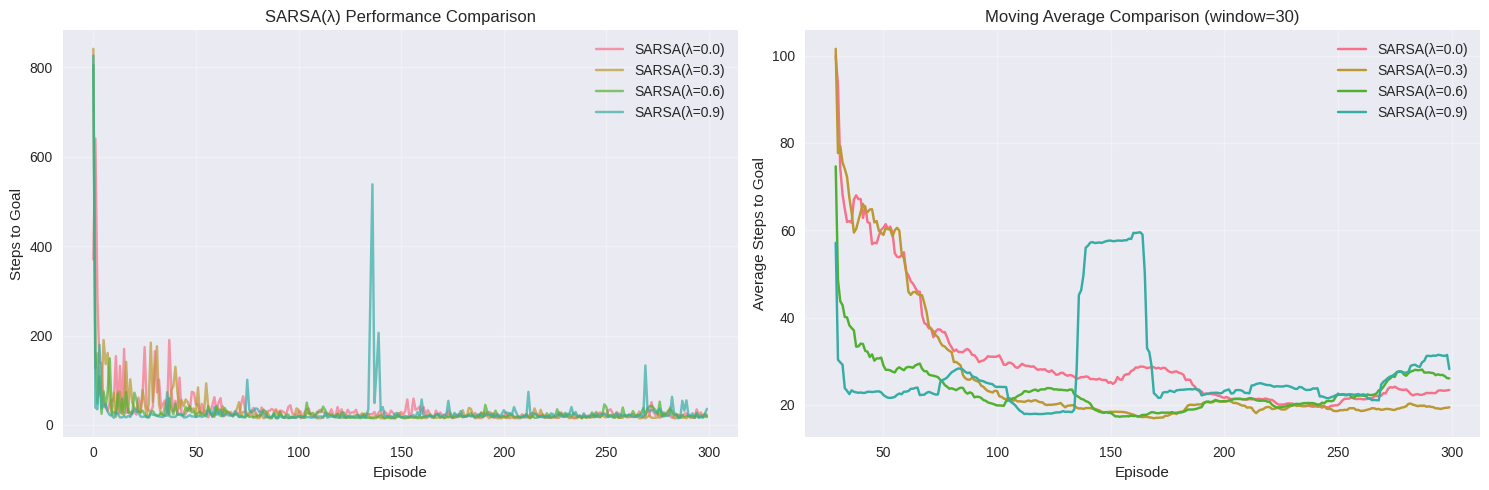


=== SARSA(λ) Performance Summary ===
SARSA(λ=0.0): 22.80 ± 6.40 steps
SARSA(λ=0.3): 19.30 ± 4.55 steps
SARSA(λ=0.6): 25.06 ± 8.44 steps
SARSA(λ=0.9): 27.44 ± 18.02 steps


In [9]:
class TDLambdaAgent:
    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1, lambda_=0.9):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_

        # Initialize Q-table and eligibility traces
        self.Q = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.episode_lengths = []

    def epsilon_greedy_policy(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.get_valid_actions(state))
        else:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
            return np.random.choice(best_actions)

    def train_episode(self):
        """Train for one episode using SARSA(λ)"""
        state = self.env.reset()
        action = self.epsilon_greedy_policy(state)

        # Initialize eligibility traces for this episode
        eligibility = defaultdict(lambda: defaultdict(float))

        episode_reward = 0
        steps = 0

        while True:
            # Take action
            next_state, reward, done = self.env.step(action)
            episode_reward += reward
            steps += 1

            if done:
                # Terminal state
                delta = reward - self.Q[state][action]
                eligibility[state][action] += 1

                # Update all state-action pairs
                for s in eligibility:
                    for a in eligibility[s]:
                        self.Q[s][a] += self.alpha * delta * eligibility[s][a]
                break
            else:
                # Choose next action
                next_action = self.epsilon_greedy_policy(next_state)

                # Calculate TD error
                delta = reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]

                # Update eligibility trace for current state-action
                eligibility[state][action] += 1

                # Update all state-action pairs
                for s in list(eligibility.keys()):
                    for a in list(eligibility[s].keys()):
                        self.Q[s][a] += self.alpha * delta * eligibility[s][a]
                        eligibility[s][a] *= self.gamma * self.lambda_

                        # Remove trace if too small
                        if eligibility[s][a] < 1e-8:
                            del eligibility[s][a]

                    # Remove state if no actions left
                    if not eligibility[s]:
                        del eligibility[s]

                # Move to next state-action pair
                state = next_state
                action = next_action

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)
        return episode_reward, steps

    def get_policy(self):
        """Extract greedy policy from Q-values"""
        policy = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            best_action = actions[np.argmax(q_values)]
            policy[state] = best_action
        return policy

    def get_state_values(self):
        """Extract state values from Q-values"""
        values = {}
        for state in self.Q:
            actions = self.env.get_valid_actions(state)
            q_values = [self.Q[state][a] for a in actions]
            values[state] = max(q_values) if q_values else 0
        return values

# Compare different λ values
lambda_values = [0.0, 0.3, 0.6, 0.9]
td_lambda_agents = []

print("Training SARSA(λ) agents with different λ values...")
for lambda_val in lambda_values:
    env = WindyGridworld()
    agent = TDLambdaAgent(env, alpha=0.5, epsilon=0.1, lambda_=lambda_val)

    print(f"Training λ = {lambda_val}...")
    episodes = 300
    for episode in tqdm(range(episodes), desc=f"λ={lambda_val}"):
        agent.train_episode()

    td_lambda_agents.append((f"SARSA(λ={lambda_val})", agent))

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for name, agent in td_lambda_agents:
    plt.plot(agent.episode_lengths, label=name, alpha=0.7)

plt.title('SARSA(λ) Performance Comparison')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
window = 30
for name, agent in td_lambda_agents:
    moving_avg = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(agent.episode_lengths)), moving_avg, label=name)

plt.title(f'Moving Average Comparison (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final performance
print("\n=== SARSA(λ) Performance Summary ===")
for name, agent in td_lambda_agents:
    final_avg = np.mean(agent.episode_lengths[-50:])
    final_std = np.std(agent.episode_lengths[-50:])
    print(f"{name}: {final_avg:.2f} ± {final_std:.2f} steps")

## 6.9 Key Insights and Summary

### Algorithm Characteristics:

1. **SARSA (On-policy)**:
   - Updates based on actual policy behavior
   - More conservative, learns safe paths
   - Converges to policy being followed

2. **Q-Learning (Off-policy)**:
   - Updates based on optimal future actions
   - More aggressive exploration
   - Converges to optimal policy regardless of behavior policy

3. **Expected SARSA**:
   - Uses expected value over all actions
   - More stable than SARSA
   - Can be both on-policy and off-policy

4. **Double Q-Learning**:
   - Addresses maximization bias
   - Uses two Q-tables for more accurate estimates
   - Better performance in stochastic environments

5. **SARSA(λ)**:
   - Bridges temporal difference and Monte Carlo
   - λ controls the balance between immediacy and long-term credit
   - Faster learning through eligibility traces

/tmp/ipython-input-4003997675.py:107: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(moving_avg[:200] if len(moving_avg) >= 200 else moving_avg)


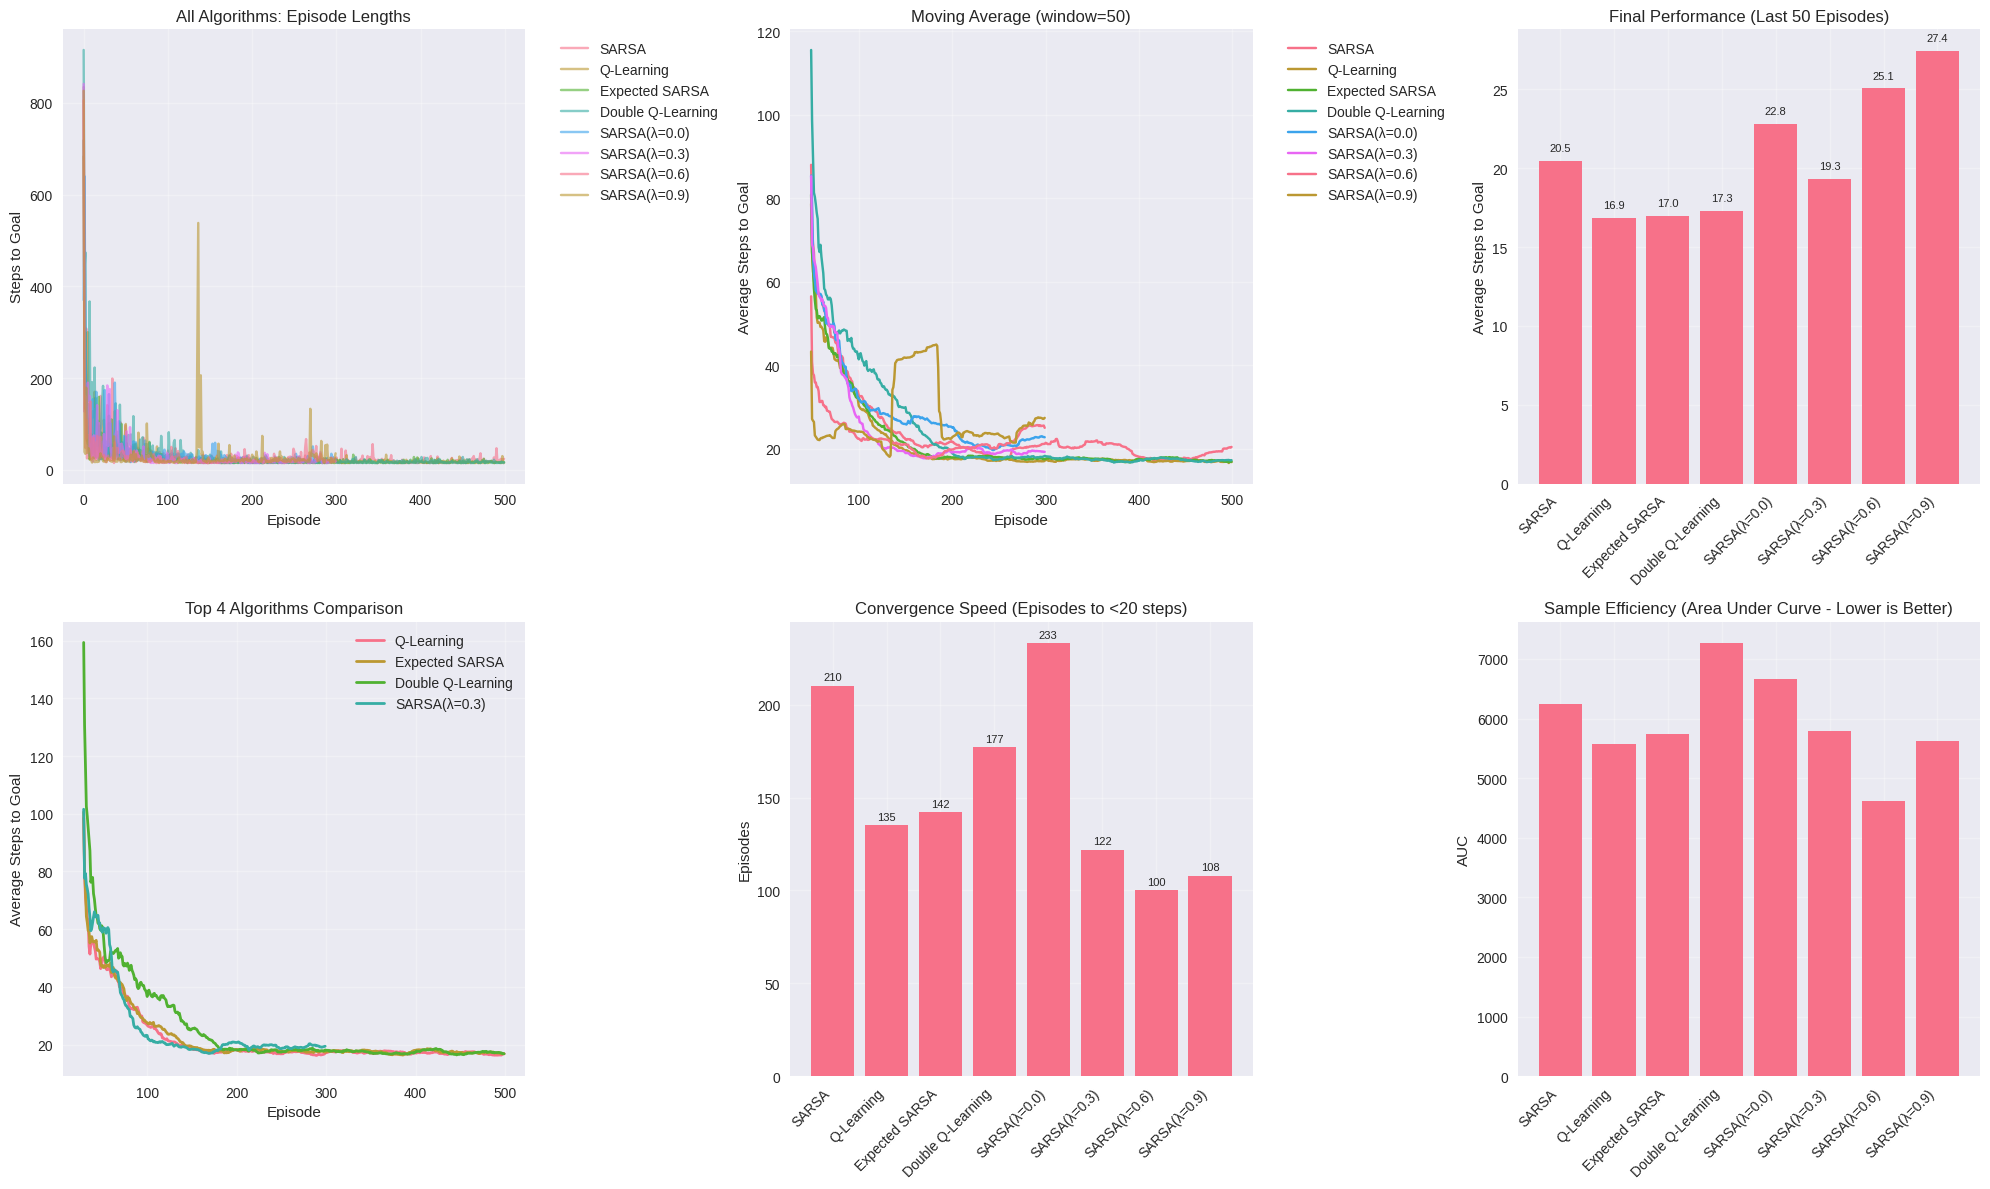


=== Complete Algorithm Analysis ===
Algorithm            Final Perf   Convergence  Sample Eff  
------------------------------------------------------------
SARSA                20.5         210          6247        
Q-Learning           16.9         135          5569        
Expected SARSA       17.0         142          5740        
Double Q-Learning    17.3         177          7260        
SARSA(λ=0.0)         22.8         233          6659        
SARSA(λ=0.3)         19.3         122          5784        
SARSA(λ=0.6)         25.1         100          4623        
SARSA(λ=0.9)         27.4         108          5616        


In [10]:
# Create a comprehensive comparison plot
plt.figure(figsize=(20, 12))

# Combine all agents for comparison
all_agents = [
    ('SARSA', sarsa_agent),
    ('Q-Learning', qlearning_agent),
    ('Expected SARSA', expected_sarsa_agent),
    ('Double Q-Learning', double_q_agent),
] + td_lambda_agents

# Episode lengths
plt.subplot(2, 3, 1)
for name, agent in all_agents:
    plt.plot(agent.episode_lengths, label=name, alpha=0.6)
plt.title('All Algorithms: Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Moving averages
plt.subplot(2, 3, 2)
window = 50
for name, agent in all_agents:
    if len(agent.episode_lengths) >= window:
        moving_avg = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(agent.episode_lengths)), moving_avg, label=name)
plt.title(f'Moving Average (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Steps to Goal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Final performance bar chart
plt.subplot(2, 3, 3)
names = []
performances = []
for name, agent in all_agents:
    names.append(name)
    performances.append(np.mean(agent.episode_lengths[-50:]))

bars = plt.bar(range(len(names)), performances)
plt.title('Final Performance (Last 50 Episodes)')
plt.ylabel('Average Steps to Goal')
plt.xticks(range(len(names)), names, rotation=45, ha='right')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, performances)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}', ha='center', va='bottom', fontsize=8)

plt.grid(True, alpha=0.3)

# Learning curves for top 4 performers
plt.subplot(2, 3, 4)
sorted_agents = sorted(all_agents, key=lambda x: np.mean(x[1].episode_lengths[-50:]))
top_4 = sorted_agents[:4]

for name, agent in top_4:
    window = 30
    moving_avg = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(agent.episode_lengths)), moving_avg, label=name, linewidth=2)

plt.title('Top 4 Algorithms Comparison')
plt.xlabel('Episode')
plt.ylabel('Average Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

# Convergence analysis
plt.subplot(2, 3, 5)
convergence_episodes = []
threshold = 20

for name, agent in all_agents:
    window = 30
    if len(agent.episode_lengths) >= window:
        moving_avg = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
        converged = np.where(moving_avg < threshold)[0]
        if len(converged) > 0:
            convergence_episodes.append(converged[0] + window - 1)
        else:
            convergence_episodes.append(len(agent.episode_lengths))
    else:
        convergence_episodes.append(len(agent.episode_lengths))

bars = plt.bar(range(len(names)), convergence_episodes)
plt.title(f'Convergence Speed (Episodes to <{threshold} steps)')
plt.ylabel('Episodes')
plt.xticks(range(len(names)), names, rotation=45, ha='right')

for i, (bar, value) in enumerate(zip(bars, convergence_episodes)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{value}', ha='center', va='bottom', fontsize=8)

plt.grid(True, alpha=0.3)

# Sample efficiency comparison
plt.subplot(2, 3, 6)
sample_efficiency = []
for name, agent in all_agents:
    # Calculate area under the learning curve (lower is better)
    window = 30
    if len(agent.episode_lengths) >= window:
        moving_avg = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
        auc = np.trapz(moving_avg[:200] if len(moving_avg) >= 200 else moving_avg)
        sample_efficiency.append(auc)
    else:
        sample_efficiency.append(np.sum(agent.episode_lengths))

bars = plt.bar(range(len(names)), sample_efficiency)
plt.title('Sample Efficiency (Area Under Curve - Lower is Better)')
plt.ylabel('AUC')
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Complete Algorithm Analysis ===")
print(f"{'Algorithm':<20} {'Final Perf':<12} {'Convergence':<12} {'Sample Eff':<12}")
print("-" * 60)
for i, (name, agent) in enumerate(all_agents):
    final_perf = np.mean(agent.episode_lengths[-50:])
    conv_speed = convergence_episodes[i]
    samp_eff = sample_efficiency[i]
    print(f"{name:<20} {final_perf:<12.1f} {conv_speed:<12d} {samp_eff:<12.0f}")

## 🎯 Chapter 6 Summary

This notebook demonstrated advanced Q-learning variants and their comparative performance:

### Key Takeaways:

1. **Algorithm Selection**: Choice depends on problem characteristics
   - **Stochastic environments**: Double Q-Learning or Expected SARSA
   - **Safety-critical applications**: SARSA (on-policy)
   - **Sample efficiency**: SARSA(λ) with appropriate λ
   - **General purpose**: Q-Learning or Expected SARSA

2. **λ Parameter in TD(λ)**:
   - λ = 0: Pure TD (immediate updates)
   - λ = 1: Monte Carlo (episode-based updates)
   - Intermediate values: Balance between bias and variance

3. **Practical Considerations**:
   - Memory usage: TD(λ) requires eligibility traces
   - Computational cost: Double Q-Learning requires two Q-tables
   - Convergence speed: Often problem-dependent

### References:
- [1] Sutton, R. S., & Barto, A. G. (2018). *Reinforcement learning: An introduction*
- [4] Watkins, C. J., & Dayan, P. (1992). Q-learning. *Machine learning*
- [6] Van Hasselt, H., et al. (2016). Deep reinforcement learning with double q-learning
- [8] Williams, R. J. (1992). Simple statistical gradient-following algorithms for connectionist reinforcement learning

### Cross-References:
- **Previous**: [Chapter 5: Temporal Difference Learning](chapter05_temporal_difference.ipynb)
- **Next**: [Chapter 7: Function Approximation](chapter07_function_approximation.ipynb)
- **Related**: [Chapter 4: Monte Carlo Methods](chapter04_monte_carlo.ipynb)

### Next Steps:
- Chapter 7: Function Approximation
- Chapter 8: Deep Reinforcement Learning
- Experiment with different environments and hyperparameters

---
*This notebook is part of the Reinforcement Learning for Engineer-Mathematicians textbook. For complete bibliography, see [bibliography.md](bibliography.md)*